In [1]:
import pandas as pd  
import numpy as np
from scipy import stats  
from math import log 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

2023-12-25 17:18:56.182043: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-25 17:18:56.484645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 17:18:56.484677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 17:18:56.486540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 17:18:56.613538: I tensorflow/core/platform/cpu_feature_g

In [16]:
AP18 = pd.read_excel(r"/home/ale/feature_extraction_classification_taxa/feature_table_AP18_feature_extraction.xlsx", index_col = 0)

In [17]:
CRC18 = pd.read_excel(r"/home/ale/feature_extraction_classification_taxa/feature_table_CRC18_feature_extraction.xlsx", index_col = 0)

In [18]:
AP_CRC = pd.concat([AP18, CRC18], axis=0)

In [19]:
AP_CRC

101637aba474a6614786486ad42acb11  \
#OTU ID                                                  
ID598-E7-FAS-31F                                  61.0   
ID598-C8-FAS-33F                                  49.0   
ID598-F8-FAS-35F                                  32.0   
1                                                 98.0   
2                                                 31.0   
3                                                142.0   
ID881-E06-FAS-21B-T0                               0.0   
ID598-H6-FAS-24B                                   0.0   
ID598-F7-FAS-31B                                  12.0   
1                                                158.0   
2                                                144.0   
3                                                 95.0   
ID598-D7-FAS-31S                               45797.0   
ID598-B8-FAS-33S                                5534.0   
ID598-E8-FAS-35S                                 876.0   
1                                              24954.0   
2                                              38281.0   
3                                                876.0   
ID598-B1-FAS-1F                                  105.0   
ID598-B10-FAS-44F                               1261.0   
ID598-B4-FAS-10F                                   0.0   
1                                                429.0   
2                                                122.0   
3                                                473.0   
ID598-A8-FAS-32B                                1133.0   
ID598-B3-FAS-7B                                   41.0   
ID598-B6-FAS-20B                                 101.0   
1                                                  0.0   
2                                                  0.0   
3                                                230.0   
ID598-A4-FAS-10S                                3677.0   
ID598-A7-FAS-30S                                5177.0   
ID598-B2-FAS-5S                                 5871.0   
1                                               4574.0   
2                                               3227.0   
3                                              33409.0   

                      ffc36e27c82042664a16bcd4d380b286  \
#OTU ID                                                  
ID598-E7-FAS-31F                                   0.0   
ID598-C8-FAS-33F                                  53.0   
ID598-F8-FAS-35F                                  14.0   
1                                               3680.0   
2                                                637.0   
3                                               3939.0   
ID881-E06-FAS-21B-T0                              51.0   
ID598-H6-FAS-24B                                1682.0   
ID598-F7-FAS-31B                                  84.0   
1                                              25906.0   
2                                              50917.0   
3                                              94162.0   
ID598-D7-FAS-31S                                   0.0   
ID598-B8-FAS-33S                                   0.0   
ID598-E8-FAS-35S                                   0.0   
1                                                 23.0   
2                                                  5.0   
3                                                  0.0   
ID598-B1-FAS-1F                                  454.0   
ID598-B10-FAS-44F                                130.0   
ID598-B4-FAS-10F                                 780.0   
1                                               4695.0   
2                                                  0.0   
3                                               2073.0   
ID598-A8-FAS-32B                               30758.0   
ID598-B3-FAS-7B                                    0.0   
ID598-B6-FAS-20B                                4857.0   
1                                               3555.0   
2                                               7456.0   
3                  

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

AP_CRC['target'] = [0] * 18 + [1] * 18

x = AP_CRC.iloc[:, :-1]
y = AP_CRC.iloc[:, -1]

num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_per_fold = []
selected_columns_per_activation = {}

def perform_lrp(model, input_data):
    get_layer_output = tf.keras.backend.function([model.layers[0].input], [layer.output for layer in model.layers])
    intermediate_activations = get_layer_output(input_data)

    relevance = model.predict(input_data)

    for i in range(len(model.layers) - 1, 0, -1):
        layer = model.layers[i]
        activation = intermediate_activations[i - 1]

        if isinstance(layer, Dense):
            W, b = layer.get_weights()
            Z = np.dot(activation, W) + b
            S = relevance / (Z + 1e-10)
            C = np.dot(S, W.T)
            relevance = activation * C

    input_relevance = relevance.flatten()

    return input_relevance

activation_functions = ['relu', 'LeakyReLU', 'softmax', 'gelu']

for activation_function in activation_functions:
    print(f"\nTesting Activation Function: {activation_function}")

    lrp_scores_per_fold = []
    selected_columns_per_fold = []
    
    accuracy_scores_for_activation = []

    for fold, (train_index, test_index) in enumerate(skf.split(x, y)):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = Sequential()

        if activation_function == 'LeakyReLU':
            model.add(Dense(64, activation=LeakyReLU(alpha=0.01), input_shape=(10329,)))
            model.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
        else:
            model.add(Dense(64, activation=activation_function, input_shape=(10329,)))
            model.add(Dense(32, activation=activation_function))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(x_train, y_train, epochs=45, batch_size=32, verbose=0)

        y_pred = (model.predict(x_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        
        accuracy_scores_for_activation.append(accuracy)

        lrp_scores_all_samples = []

        for sample_index in range(len(x_test)):
            input_data_sample = np.expand_dims(x_test.iloc[sample_index].values, axis=0)
            lrp_scores_sample = perform_lrp(model, input_data_sample)
            lrp_scores_all_samples.append(lrp_scores_sample)
 
        lrp_scores_all_samples = np.array(lrp_scores_all_samples)

        mean_lrp_scores = np.mean(lrp_scores_all_samples, axis=0)

        top_features_indices = np.argsort(mean_lrp_scores)[::-1]

        lrp_scores_per_fold.append(mean_lrp_scores)
        selected_columns_per_fold.append(x.columns[top_features_indices])

        print(f"Fold {fold + 1} Accuracy: {accuracy}")

    average_accuracy_for_activation = np.mean(accuracy_scores_for_activation)
    accuracy_scores_per_fold.append(average_accuracy_for_activation)

    mean_lrp_scores_across_folds = np.mean(lrp_scores_per_fold, axis=0)
    top_features_indices_across_folds = np.argsort(mean_lrp_scores_across_folds)[::-1]

    selected_columns_across_folds = x.columns[top_features_indices_across_folds]

    selected_columns_per_activation[activation_function] = selected_columns_across_folds

    print(f"\nTop Feature Indices Across All Folds - {activation_function}: {top_features_indices_across_folds}")
    print(f"Selected Columns Across All Folds - {activation_function}:")
    print(selected_columns_across_folds)
    
for i, activation_function in enumerate(activation_functions):
    print(f"\nAverage Accuracy for Activation Function {activation_function}: {accuracy_scores_per_fold[i]}")

print("\nSelected Columns for All Activation Functions:")
for activation_function, selected_columns in selected_columns_per_activation.items():
    print(f"{activation_function}: {selected_columns}")



Testing Activation Function: relu


2023-12-05 17:25:09.951714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 17:25:10.147047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 17:25:10.147301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 0s 12ms/step
Fold 1 Accuracy: 0.5
1/1 [==============================] - 0s 13ms/step
Fold 2 Accuracy: 0.5
1/1 [==============================] - 0s 12ms/step
Fold 3 Accuracy: 0.75
1/1 [==============================] - 0s 12ms/step
Fold 4 Accuracy: 0.5
1/1 [==============================] - 0s 12ms/step
Fold 5 Accuracy: 0.75
1/1 [==============================] - 0s 12ms/step
Fold 6 Accuracy: 0.75
1/1 [==============================] - 0s 12ms/step
Fold 7 Accuracy: 1.0
1/1 [==============================] - 0s 12ms/step
Fold 8 Accuracy: 1.0
1/1 [==============================] - 0s 13ms/step
Fold 9 Accuracy: 0.6666666666666666
1/1 [==============================] - 0s 13ms/step
Fold 10 Accuracy: 1.0

Top Feature Indices Across All Folds - relu: [35 25 14  1 62 13  7  3 38 60  4 17 49 27 50 37 57 45 39 52 33 43 31 29
 61 26 42 21 18 20 51 23 19 54 12 16 15 58 53 11 63 47 32 22 24  9 41 48
 59 55 10  0 56 46  2 36 30 44  8 34 40 28  6  5]
Selected 

In [21]:
features = selected_columns_per_activation['LeakyReLU']

In [22]:
features

('73b9a313c153726841a55e295f19bdb5',
 '4abaa483334092f021534a979086baeb',
 '8f3c8cb8544640becafb5777eb7a5858',
 '11902be998c8092e98cbe98af2f648af',
 '0dea7be1e56d386113c1ba0044285af7',
 '866ea1cc638e4ceb9195a8a6a1869754',
 '571d1a0b0be4207e7f8c8f772047a11f',
 'a5b69f125c8e15c8b470bd65ffa241c1',
 '9ec59f2e602a8b8804d9bada68700195',
 '3c3c05b27064591a63bdabfe89ee6022',
 '9cd1a7d9a0501bb91a69b628378d521f',
 'f1681bcc5274382eaf70ad85491c837e',
 '6a57339163b1db2da81ab332dc9b1823',
 '70d55baf78e9ac4d0babeac5dcbae5c2',
 '55ae36374045b6a58fdc9c11936be5cc',
 '98fcc7e4135d41152d2db711de5c1255',
 'e1ae03f7469bbc8719128f141c3c47aa',
 '44536e7d859312677ce835c0cb53eeca',
 '224d266b147588a000917723c0268775',
 'ffc36e27c82042664a16bcd4d380b286',
 'bbae6ed124f4d6b48435a964a95c8418',
 '7b6d335d29fb8edf989ba7d03a848d84',
 '2f97492ef9c9571e2e76166dde9d64eb',
 '7440aa816171ce9e81d9b67d2dda61c6',
 'b264ac8ff5f9aff74f0b9aa084d9a9f0',
 'dfa833b266bd2993b86feab3617b34c3',
 'f148c9872201cbd90a403cf63b13e46c',
 

In [23]:
taxonomy = pd.read_csv(r'/home/ale/datasets tesi/GSE217490_taxonomy.csv', index_col = 0)

In [24]:
taxonomy

Taxon  \
Feature ID                                                                            
d2056d7ce9b69aef41f72d361c733f7b  d__Bacteria; p__Fusobacteriota; c__Fusobacteri...   
dfa833b266bd2993b86feab3617b34c3  d__Bacteria; p__Verrucomicrobiota; c__Verrucom...   
d386863b6a0565708ae63f7aec6cec88  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...   
3c3c05b27064591a63bdabfe89ee6022  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...   
47f3d645d96038371757074de1d8fb8d  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...   
...                                                                             ...   
59fe9f14076439e124f9fed524d4ef4a                                         Unassigned   
60be2b7ada8c160670284b278791b3a8                                         Unassigned   
e1efc155face91b4e21fe4da14869d85                                         Unassigned   
1498db50e0ef1dd8c7c541bde02a0241                                         Unassigned   
af6791b9199c912733a5177350ef10d8  d__Bacteria; p__Proteobacteria; c__Gammaproteo...   

                                  Consensus  
Feature ID                                   
d2056d7ce9b69aef41f72d361c733f7b      0.600  
dfa833b266bd2993b86feab3617b34c3      1.000  
d386863b6a0565708ae63f7aec6cec88      1.000  
3c3c05b27064591a63bdabfe89ee6022      0.900  
47f3d645d96038371757074de1d8fb8d      0.800  
...                                     ...  
59fe9f14076439e124f9fed524d4ef4a      1.000  
60be2b7ada8c160670284b278791b3a8      1.000  
e1efc155face91b4e21fe4da14869d85      1.000  
1498db50e0ef1dd8c7c541bde02a0241      1.000  
af6791b9199c912733a5177350ef10d8      0.875  

[10329 rows x 2 columns]

In [25]:
taxa = taxonomy.loc[features,:]

In [26]:
taxa

Taxon  \
Feature ID                                                                            
73b9a313c153726841a55e295f19bdb5  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
4abaa483334092f021534a979086baeb  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...   
8f3c8cb8544640becafb5777eb7a5858  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
11902be998c8092e98cbe98af2f648af  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
0dea7be1e56d386113c1ba0044285af7  d__Bacteria; p__Actinobacteriota; c__Actinobac...   
...                                                                             ...   
5354b5f62e45014a1b54b8ad68cfa269  d__Bacteria; p__Firmicutes; c__Negativicutes; ...   
15e05255b2aa8ee3524ca61eb207bb18  d__Bacteria; p__Actinobacteriota; c__Coriobact...   
f7cf33648c7d6bda19e991b97583cdab  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...   
13785f0aa34992209c67c3caeebbd429  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
e9398bc0ad9626bc4742c93fd0363bac  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   

                                  Consensus  
Feature ID                                   
73b9a313c153726841a55e295f19bdb5        0.7  
4abaa483334092f021534a979086baeb        1.0  
8f3c8cb8544640becafb5777eb7a5858        1.0  
11902be998c8092e98cbe98af2f648af        0.9  
0dea7be1e56d386113c1ba0044285af7        1.0  
...                                     ...  
5354b5f62e45014a1b54b8ad68cfa269        1.0  
15e05255b2aa8ee3524ca61eb207bb18        1.0  
f7cf33648c7d6bda19e991b97583cdab        1.0  
13785f0aa34992209c67c3caeebbd429        0.7  
e9398bc0ad9626bc4742c93fd0363bac        1.0  

[64 rows x 2 columns]

In [13]:
AP172 = pd.read_excel(r'/home/ale/datasets tesi/feature_table_AP_patients172.xlsx', index_col = 0)

In [14]:
CRC172 = pd.read_excel(r'/home/ale/datasets tesi/feature_table_CRC_patients172.xlsx', index_col = 0)

In [15]:
AP_CRC_for_class = pd.concat([AP172, CRC172], axis=0)

In [16]:
AP_CRC_for_class

101637aba474a6614786486ad42acb11  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               9.0   
ID881-F08-FAS-60F-T0                             167.0   
ID881-G09-FAS-66F-T0                               0.0   
...                                                ...   
3                                              15236.0   
4                                               2110.0   
5                                              22119.0   
6                                              31185.0   
7                                              17315.0   

                      ffc36e27c82042664a16bcd4d380b286  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                 920.0   
ID881-A07-FAS-40F-T0                             254.0   
ID881-F08-FAS-60F-T0                            3895.0   
ID881-G09-FAS-66F-T0                              34.0   
...                                                ...   
3                                                  1.0   
4                                                  0.0   
5                                                  0.0   
6                                                  1.0   
7                                                  8.0   

                      add7f5d621120b854b4f1ab2f611089e  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                               0.0   
ID881-G09-FAS-66F-T0                              12.0   
...                                                ...   
3                                              11337.0   
4                                               9567.0   
5                                               8945.0   
6                                               1473.0   
7                                               4032.0   

                      dfa833b266bd2993b86feab3617b34c3  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                           35659.0   
ID598-G6-FAS-24F                                 405.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                             866.0   
ID881-G09-FAS-66F-T0                               0.0   
...                                                ...   
3                                                  1.0   
4                                                  0.0   
5                                                  0.0   
6                                                  1.0   
7                                                  0.0   

                      47f3d645d96038371757074de1d8fb8d  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                               0.0   
ID881-G09-FAS-66F-T0                               0.0   
...                                                ...   
3                                                  1.0   
4                                                  1.0   
5                                                  2.0   
6                                                  0.0   
7                                                 43.0   

                      24522f7485582e07564aed7c426af59d  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-4

In [18]:
dataframe = AP_CRC_for_class.loc[:, features]

In [19]:
dataframe

7ed7c63052602e4a792245ae6a1b473b  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                               0.0   
ID881-G09-FAS-66F-T0                               0.0   
...                                                ...   
3                                                  0.0   
4                                                  3.0   
5                                                  1.0   
6                                                  0.0   
7                                                 30.0   

                      e9398bc0ad9626bc4742c93fd0363bac  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                               0.0   
ID881-G09-FAS-66F-T0                            1129.0   
...                                                ...   
3                                                  0.0   
4                                                  0.0   
5                                                  0.0   
6                                                  0.0   
7                                                  0.0   

                      841ea34437228d9fa66de17a4edfdaec  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                               0.0   
ID881-G09-FAS-66F-T0                               4.0   
...                                                ...   
3                                                961.0   
4                                                  0.0   
5                                                 54.0   
6                                                  0.0   
7                                                775.0   

                      4516aa60a483dd8c7bbc57098c45f1a5  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                 134.0   
ID881-A07-FAS-40F-T0                            1008.0   
ID881-F08-FAS-60F-T0                            1498.0   
ID881-G09-FAS-66F-T0                             305.0   
...                                                ...   
3                                                  0.0   
4                                                  0.0   
5                                                  0.0   
6                                                  0.0   
7                                                  0.0   

                      add7f5d621120b854b4f1ab2f611089e  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                   0.0   
ID881-A07-FAS-40F-T0                               0.0   
ID881-F08-FAS-60F-T0                               0.0   
ID881-G09-FAS-66F-T0                              12.0   
...                                                ...   
3                                              11337.0   
4                                               9567.0   
5                                               8945.0   
6                                               1473.0   
7                                               4032.0   

                      22f4ee9a41a4d73580bf7ade8e9e017a  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                               0.0   
ID598-G6-FAS-24F                                  18.0   
ID881-A07-FAS-4

In [20]:
dataframe.to_excel('/home/ale/datasets tesi/feature_extracted.xlsx')

In [27]:
taxa.to_excel('/home/ale/datasets tesi/taxon_extracted_ordered.xlsx')

In [3]:
feature_extracted = pd.read_excel(r'/home/ale/datasets tesi/feature_extracted_for_classification.xlsx', index_col = 0)

In [4]:
feature_extracted

7ed7c63052602e4a792245ae6a1b473b  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                                 0   
...                                                ...   
3                                                    0   
4                                                    3   
5                                                    1   
6                                                    0   
7                                                   30   

                      e9398bc0ad9626bc4742c93fd0363bac  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                              1129   
...                                                ...   
3                                                    0   
4                                                    0   
5                                                    0   
6                                                    0   
7                                                    0   

                      841ea34437228d9fa66de17a4edfdaec  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                                 4   
...                                                ...   
3                                                  961   
4                                                    0   
5                                                   54   
6                                                    0   
7                                                  775   

                      4516aa60a483dd8c7bbc57098c45f1a5  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                   134   
ID881-A07-FAS-40F-T0                              1008   
ID881-F08-FAS-60F-T0                              1498   
ID881-G09-FAS-66F-T0                               305   
...                                                ...   
3                                                    0   
4                                                    0   
5                                                    0   
6                                                    0   
7                                                    0   

                      add7f5d621120b854b4f1ab2f611089e  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                                12   
...                                                ...   
3                                                11337   
4                                                 9567   
5                                                 8945   
6                                                 1473   
7                                                 4032   

                      22f4ee9a41a4d73580bf7ade8e9e017a  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                    18   
ID881-A07-FAS-4

In [5]:
taxon_in_common = pd.read_excel(r'/home/ale/datasets tesi/taxa_in_common_warticle.xlsx', index_col = 0)

In [6]:
taxon_in_common 

Taxon  \
35fd41579b5eec27ec14c400c586c480  d__Bacteria; p__Firmicutes; c__Negativicutes; ...   
f148c9872201cbd90a403cf63b13e46c  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
2f97492ef9c9571e2e76166dde9d64eb  d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...   
9ec59f2e602a8b8804d9bada68700195  d__Bacteria; p__Proteobacteria; c__Gammaproteo...   
7b6d335d29fb8edf989ba7d03a848d84  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
98c60003caac4798b6e9a0da3102d2dd  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
409f711b59152d57926cf444c5577087  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
6e7317c14238561fe5865674e3a3206d  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
dfa833b266bd2993b86feab3617b34c3  d__Bacteria; p__Verrucomicrobiota; c__Verrucom...   
13785f0aa34992209c67c3caeebbd429  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
8f3c8cb8544640becafb5777eb7a5858  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
bb35a35e317aeaf3cdd5bef973af2498  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
6a57339163b1db2da81ab332dc9b1823  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
b264ac8ff5f9aff74f0b9aa084d9a9f0  d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
101637aba474a6614786486ad42acb11  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
44536e7d859312677ce835c0cb53eeca  d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...   
73b9a313c153726841a55e295f19bdb5  d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
d2056d7ce9b69aef41f72d361c733f7b  d__Bacteria; p__Fusobacteriota; c__Fusobacteri...   

                                  Consensus  
35fd41579b5eec27ec14c400c586c480        1.0  
f148c9872201cbd90a403cf63b13e46c        1.0  
2f97492ef9c9571e2e76166dde9d64eb        0.9  
9ec59f2e602a8b8804d9bada68700195        1.0  
7b6d335d29fb8edf989ba7d03a848d84        0.9  
98c60003caac4798b6e9a0da3102d2dd        1.0  
409f711b59152d57926cf444c5577087        1.0  
6e7317c14238561fe5865674e3a3206d        1.0  
dfa833b266bd2993b86feab3617b34c3        1.0  
13785f0aa34992209c67c3caeebbd429        0.7  
8f3c8cb8544640becafb5777eb7a5858        1.0  
bb35a35e317aeaf3cdd5bef973af2498        1.0  
6a57339163b1db2da81ab332dc9b1823        0.9  
b264ac8ff5f9aff74f0b9aa084d9a9f0        0.6  
101637aba474a6614786486ad42acb11        1.0  
44536e7d859312677ce835c0cb53eeca        1.0  
73b9a313c153726841a55e295f19bdb5        0.7  
d2056d7ce9b69aef41f72d361c733f7b        0.6

In [8]:
taxon_in_common = taxon_in_common.T

In [9]:
taxon_in_common

35fd41579b5eec27ec14c400c586c480  \
Taxon      d__Bacteria; p__Firmicutes; c__Negativicutes; ...   
Consensus                                                1.0   

                            f148c9872201cbd90a403cf63b13e46c  \
Taxon      d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
Consensus                                                1.0   

                            2f97492ef9c9571e2e76166dde9d64eb  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...   
Consensus                                                0.9   

                            9ec59f2e602a8b8804d9bada68700195  \
Taxon      d__Bacteria; p__Proteobacteria; c__Gammaproteo...   
Consensus                                                1.0   

                            7b6d335d29fb8edf989ba7d03a848d84  \
Taxon      d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
Consensus                                                0.9   

                            98c60003caac4798b6e9a0da3102d2dd  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
Consensus                                                1.0   

                            409f711b59152d57926cf444c5577087  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
Consensus                                                1.0   

                            6e7317c14238561fe5865674e3a3206d  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
Consensus                                                1.0   

                            dfa833b266bd2993b86feab3617b34c3  \
Taxon      d__Bacteria; p__Verrucomicrobiota; c__Verrucom...   
Consensus                                                1.0   

                            13785f0aa34992209c67c3caeebbd429  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
Consensus                                                0.7   

                            8f3c8cb8544640becafb5777eb7a5858  \
Taxon      d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
Consensus                                                1.0   

                            bb35a35e317aeaf3cdd5bef973af2498  \
Taxon      d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
Consensus                                                1.0   

                            6a57339163b1db2da81ab332dc9b1823  \
Taxon      d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
Consensus                                                0.9   

                            b264ac8ff5f9aff74f0b9aa084d9a9f0  \
Taxon      d__Bacteria; p__Firmicutes; c__Clostridia; o__...   
Consensus                                                0.6   

                            101637aba474a6614786486ad42acb11  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
Consensus                                                1.0   

                            44536e7d859312677ce835c0cb53eeca  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...   
Consensus                                                1.0   

                            73b9a313c153726841a55e295f19bdb5  \
Taxon      d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...   
Consensus                                                0.7   

                            d2056d7ce9b69aef41f72d361c733f7b  
Taxon      d__Bacteria; p__Fusobacteriota; c__Fusobacteri...  
Consensus                                                0.6

In [10]:
column_list = taxon_in_common.columns.tolist()

In [11]:
feature_in_common = feature_extracted.loc[:,column_list]

In [12]:
feature_in_common

35fd41579b5eec27ec14c400c586c480  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                                 0   
...                                                ...   
3                                                    0   
4                                                   75   
5                                                   78   
6                                                   89   
7                                                    0   

                      f148c9872201cbd90a403cf63b13e46c  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                   279   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                                 0   
...                                                ...   
3                                                  594   
4                                                  489   
5                                                 3004   
6                                                  431   
7                                                  230   

                      2f97492ef9c9571e2e76166dde9d64eb  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                                 0   
ID881-F08-FAS-60F-T0                                 0   
ID881-G09-FAS-66F-T0                                 5   
...                                                ...   
3                                                 1305   
4                                                  355   
5                                                 4254   
6                                                    0   
7                                                 1835   

                      9ec59f2e602a8b8804d9bada68700195  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-40F-T0                               110   
ID881-F08-FAS-60F-T0                                38   
ID881-G09-FAS-66F-T0                              2404   
...                                                ...   
3                                                   59   
4                                                   20   
5                                                    0   
6                                                    0   
7                                                   20   

                      7b6d335d29fb8edf989ba7d03a848d84  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                    74   
ID881-A07-FAS-40F-T0                                49   
ID881-F08-FAS-60F-T0                                29   
ID881-G09-FAS-66F-T0                                 0   
...                                                ...   
3                                                    0   
4                                                    0   
5                                                    0   
6                                                    0   
7                                                    0   

                      98c60003caac4798b6e9a0da3102d2dd  \
#OTU ID                                                  
ID881-F06-FAS-21F-T0                                 0   
ID598-G6-FAS-24F                                     0   
ID881-A07-FAS-4

In [14]:
feature_in_common.to_excel(r'/home/ale/datasets tesi/features_in_common_warticle.xlsx')

In [4]:
AP_CRC_19 = pd.read_excel(r'/home/ale/feature_extraction_classification_taxa/features_in_common_warticle_for_classification.xlsx', index_col = 0)

In [5]:
AP_CRC_19

d__Bacteria; p__Firmicutes; c__Negativicutes; o__Veillonellales-Selenomonadales; f__Veillonellaceae; g__Dialister; s__uncultured_bacterium  \
#OTU ID                                                                                                                                                            
ID881-F06-FAS-21F-T0                                                  0                                                                                            
ID598-G6-FAS-24F                                                      0                                                                                            
ID881-A07-FAS-40F-T0                                                  0                                                                                            
ID881-F08-FAS-60F-T0                                                  0                                                                                            
ID881-G09-FAS-66F-T0                                                  0                                                                                            
...                                                                 ...                                                                                            
3                                                                     0                                                                                            
4                                                                    75                                                                                            
5                                                                    78                                                                                            
6                                                                    89                                                                                            
7                                                                     0                                                                                            

                      d__Bacteria; p__Firmicutes; c__Clostridia; o__Peptostreptococcales-Tissierellales; f__Peptostreptococcaceae; g__Peptostreptococcus  \
#OTU ID                                                                                                                                                    
ID881-F06-FAS-21F-T0                                                  0                                                                                    
ID598-G6-FAS-24F                                                    279                                                                                    
ID881-A07-FAS-40F-T0                                                  0                                                                                    
ID881-F08-FAS-60F-T0                                                  0                                                                                    
ID881-G09-FAS-66F-T0                                                  0                                                                                    
...                                                                 ...                                                                                    
3                                                                   594                                                                                    
4                                                                   489                                                                                    
5                                                                  3004                                                                                    
6                                                                   431                                                                                    
7                

In [6]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import shap


In [7]:
AP_CRC_19['target'] = [0] *172 + [1] * 172
X = AP_CRC_19.iloc[:, :-1]
y = AP_CRC_19.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

[0]	train-logloss:0.68895+0.00037	test-logloss:0.69014+0.00143
[100]	train-logloss:0.41681+0.00481	test-logloss:0.50155+0.05341
[200]	train-logloss:0.29136+0.00493	test-logloss:0.42166+0.07849
[300]	train-logloss:0.22225+0.00545	test-logloss:0.38387+0.09360
[400]	train-logloss:0.18017+0.00519	test-logloss:0.36096+0.10206
[500]	train-logloss:0.15288+0.00479	test-logloss:0.34827+0.10856
[600]	train-logloss:0.13333+0.00456	test-logloss:0.34012+0.11430
[700]	train-logloss:0.11874+0.00425	test-logloss:0.33558+0.11781
[800]	train-logloss:0.10742+0.00394	test-logloss:0.33290+0.12142
[829]	train-logloss:0.10458+0.00396	test-logloss:0.33267+0.12214
Test Set Accuracy: 0.8695652173913043
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        35
           1       0.86      0.88      0.87        34

    accuracy                           0.87        69
   macro avg       0.87      0.87      0.87        69
weighted avg      

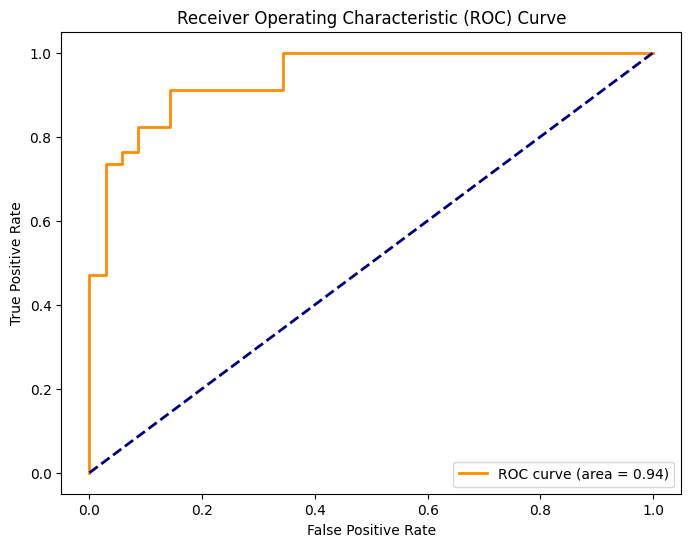

In [8]:
import xgboost
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

num_round = 5000
cv_results = xgboost.cv(
    params,
    d_train,
    num_boost_round=num_round,
    nfold=10,
    metrics="logloss",
    early_stopping_rounds=20,
    verbose_eval=100,
)

model = xgboost.train(
    params, d_train, num_boost_round=cv_results.shape[0], verbose_eval=100
)

y_pred = model.predict(d_test)

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Set Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred_binary))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('Roc_19features_dataset.png', dpi=100, bbox_inches='tight')


In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[16:07:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [9]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])
shap.initjs()

In [10]:
shap.force_plot(
    explainer.expected_value, shap_values[:344, :], X.iloc[:344, :], show = False
)


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


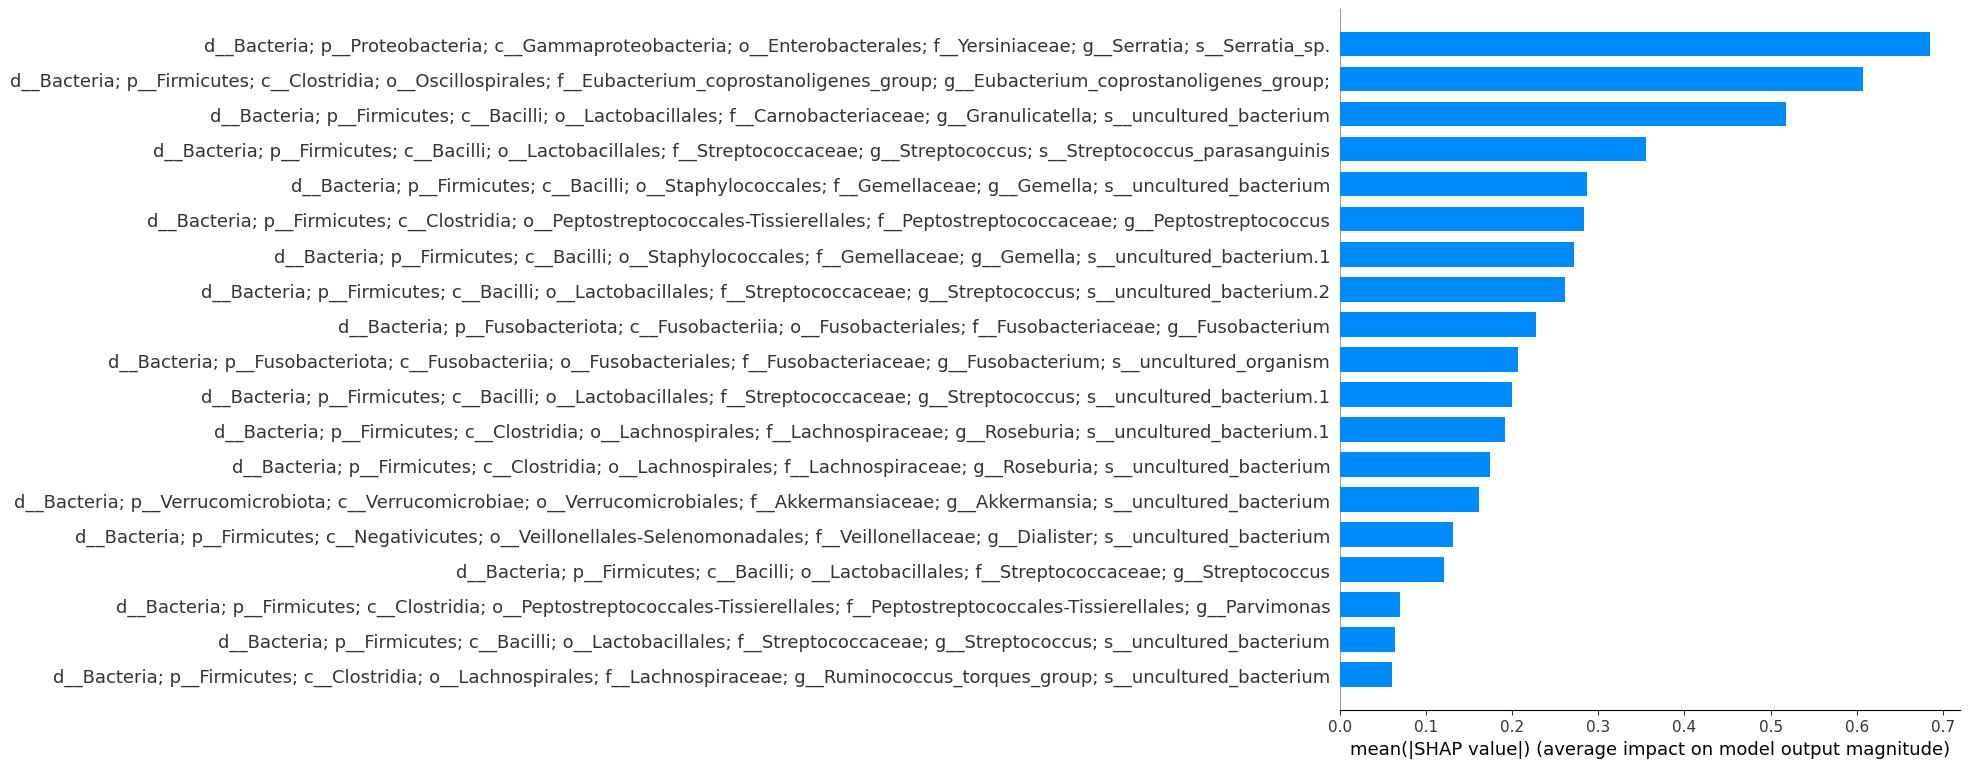

In [11]:
shap.summary_plot(shap_values, X, plot_type="bar", show = False)
plt.savefig('Shap_19features_dataset.png', dpi=55, bbox_inches='tight')

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


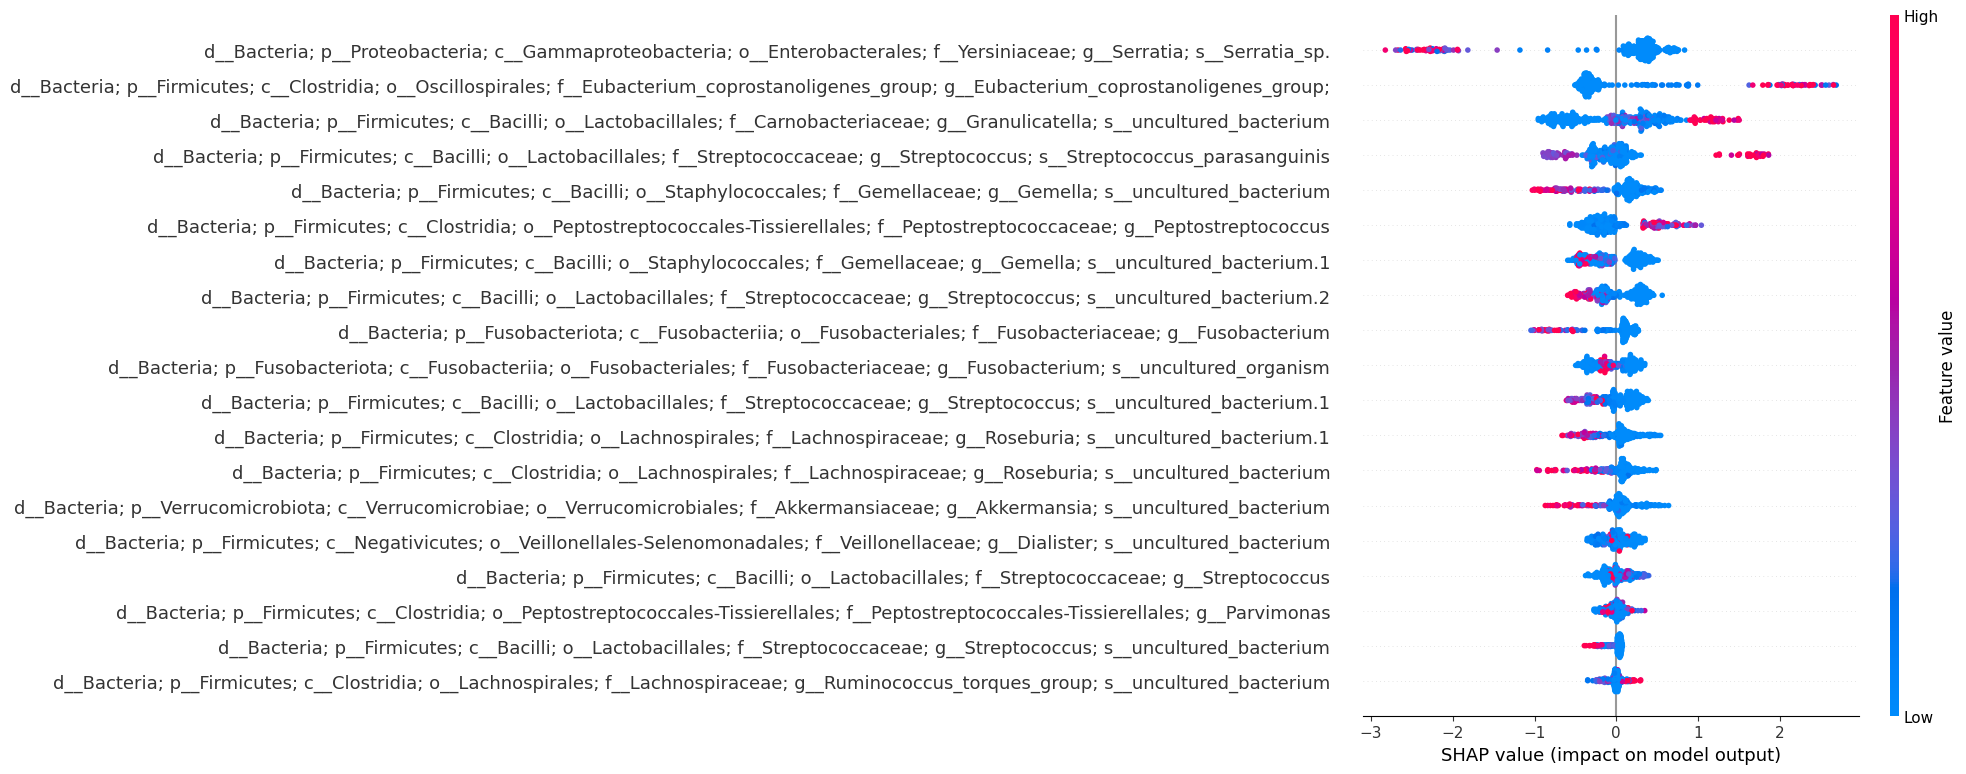

In [12]:
shap.summary_plot(shap_values, X, show = False)
plt.savefig('Shap_19features_dataset1.png', dpi=55, bbox_inches='tight')

In [13]:
AP_CRC64 = pd.read_excel(r'/home/ale/feature_extraction_classification_taxa/my_feature_extracted_for_classification.xlsx', index_col = 0)

In [14]:
AP_CRC64

d__Bacteria; p__Fusobacteriota; c__Fusobacteriia; o__Fusobacteriales; f__Fusobacteriaceae; g__Fusobacterium  \
#OTU ID                                                                                                                             
ID881-F06-FAS-21F-T0                                                  0                                                             
ID598-G6-FAS-24F                                                      0                                                             
ID881-A07-FAS-40F-T0                                                  0                                                             
ID881-F08-FAS-60F-T0                                                  0                                                             
ID881-G09-FAS-66F-T0                                                  0                                                             
...                                                                 ...                                                             
3                                                                     0                                                             
4                                                                     3                                                             
5                                                                     1                                                             
6                                                                     0                                                             
7                                                                    30                                                             

                      d__Bacteria; p__Firmicutes; c__Clostridia; o__Oscillospirales; f__Ruminococcaceae; g__Ruminococcus; s__uncultured_bacterium  \
#OTU ID                                                                                                                                             
ID881-F06-FAS-21F-T0                                                  0                                                                             
ID598-G6-FAS-24F                                                      0                                                                             
ID881-A07-FAS-40F-T0                                                  0                                                                             
ID881-F08-FAS-60F-T0                                                  0                                                                             
ID881-G09-FAS-66F-T0                                               1129                                                                             
...                                                                 ...                                                                             
3                                                                     0                                                                             
4                                                                     0                                                                             
5                                                                     0                                                                             
6                                                                     0                                                                             
7                                                                     0                                                                             

                      d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Burkholderiales; f__Neisseriaceae; g__Neisseria; s__uncultured_bacterium  \
#OTU ID                                                                                                                                                     
ID881-F06-FAS-21F-T0                    

In [15]:
import xgboost
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
AP_CRC64['target'] = [0] *172 + [1] * 172

X = AP_CRC64.iloc[:, :-1]
y = AP_CRC64.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

[0]	train-logloss:0.68860+0.00043	test-logloss:0.69002+0.00096
[100]	train-logloss:0.38802+0.00355	test-logloss:0.47171+0.03295
[200]	train-logloss:0.25080+0.00367	test-logloss:0.36654+0.04586
[300]	train-logloss:0.17863+0.00357	test-logloss:0.31213+0.05245
[400]	train-logloss:0.13659+0.00259	test-logloss:0.28025+0.05772
[500]	train-logloss:0.11073+0.00215	test-logloss:0.26036+0.06181
[600]	train-logloss:0.09315+0.00195	test-logloss:0.24532+0.06517
[700]	train-logloss:0.08097+0.00182	test-logloss:0.23397+0.06625
[800]	train-logloss:0.07198+0.00151	test-logloss:0.22849+0.06736
[900]	train-logloss:0.06498+0.00145	test-logloss:0.22364+0.06847
[1000]	train-logloss:0.05961+0.00134	test-logloss:0.22040+0.07030
[1100]	train-logloss:0.05529+0.00130	test-logloss:0.21790+0.07129
Test Set Accuracy: 0.9130434782608695
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91        35
           1       0.87      0.97      0.92      

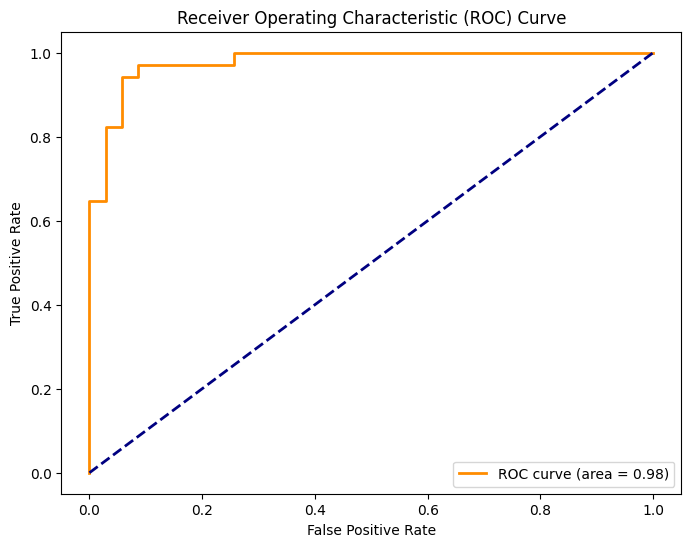

In [16]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

# Define parameters
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

num_round = 5000
cv_results = xgboost.cv(
    params,
    d_train,
    num_boost_round=num_round,
    nfold=10,
    metrics="logloss",
    early_stopping_rounds=20,
    verbose_eval=100,
)

model = xgboost.train(
    params, d_train, num_boost_round=cv_results.shape[0], verbose_eval=100
)

y_pred = model.predict(d_test)

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Set Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred_binary))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_64features_dataset.png', dpi=100, bbox_inches='tight')


In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[16:10:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [19]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])
shap.initjs()

In [20]:
shap.force_plot(
    explainer.expected_value, shap_values[:344, :], X.iloc[:344, :],
show = False)


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


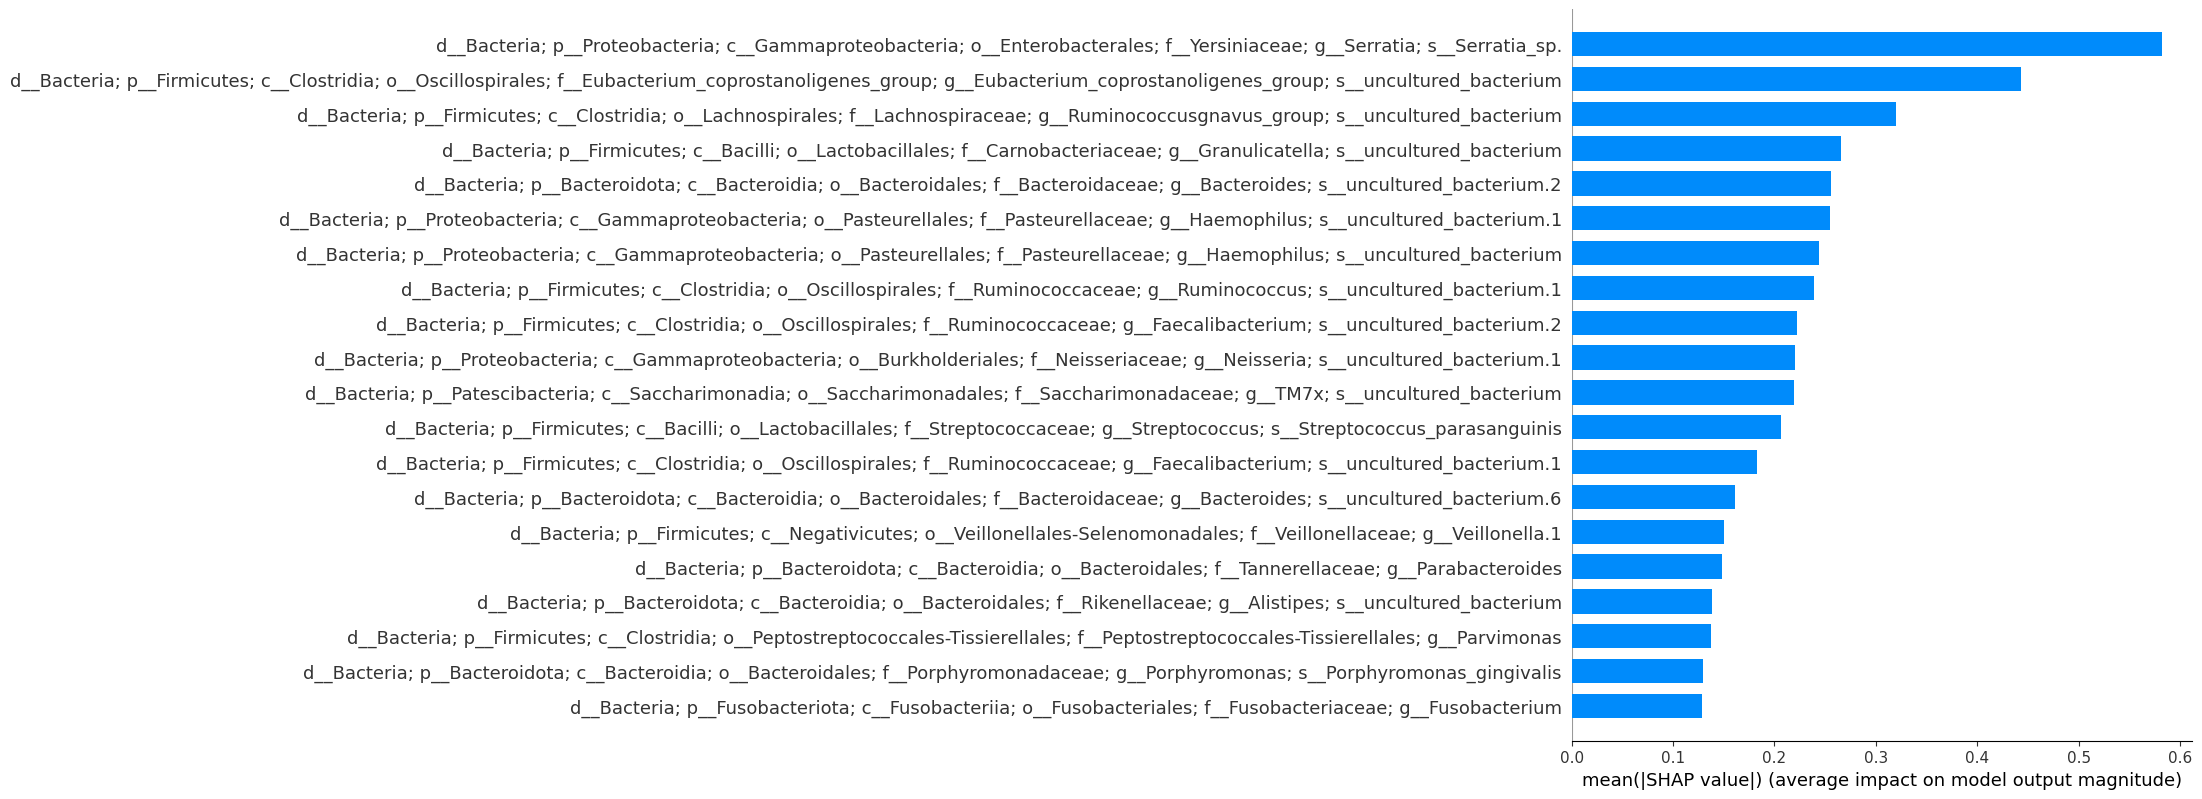

In [22]:
shap.summary_plot(shap_values, X, plot_type="bar", show = False)
plt.savefig('Shap_64features_dataset.png', dpi=55, bbox_inches='tight')

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


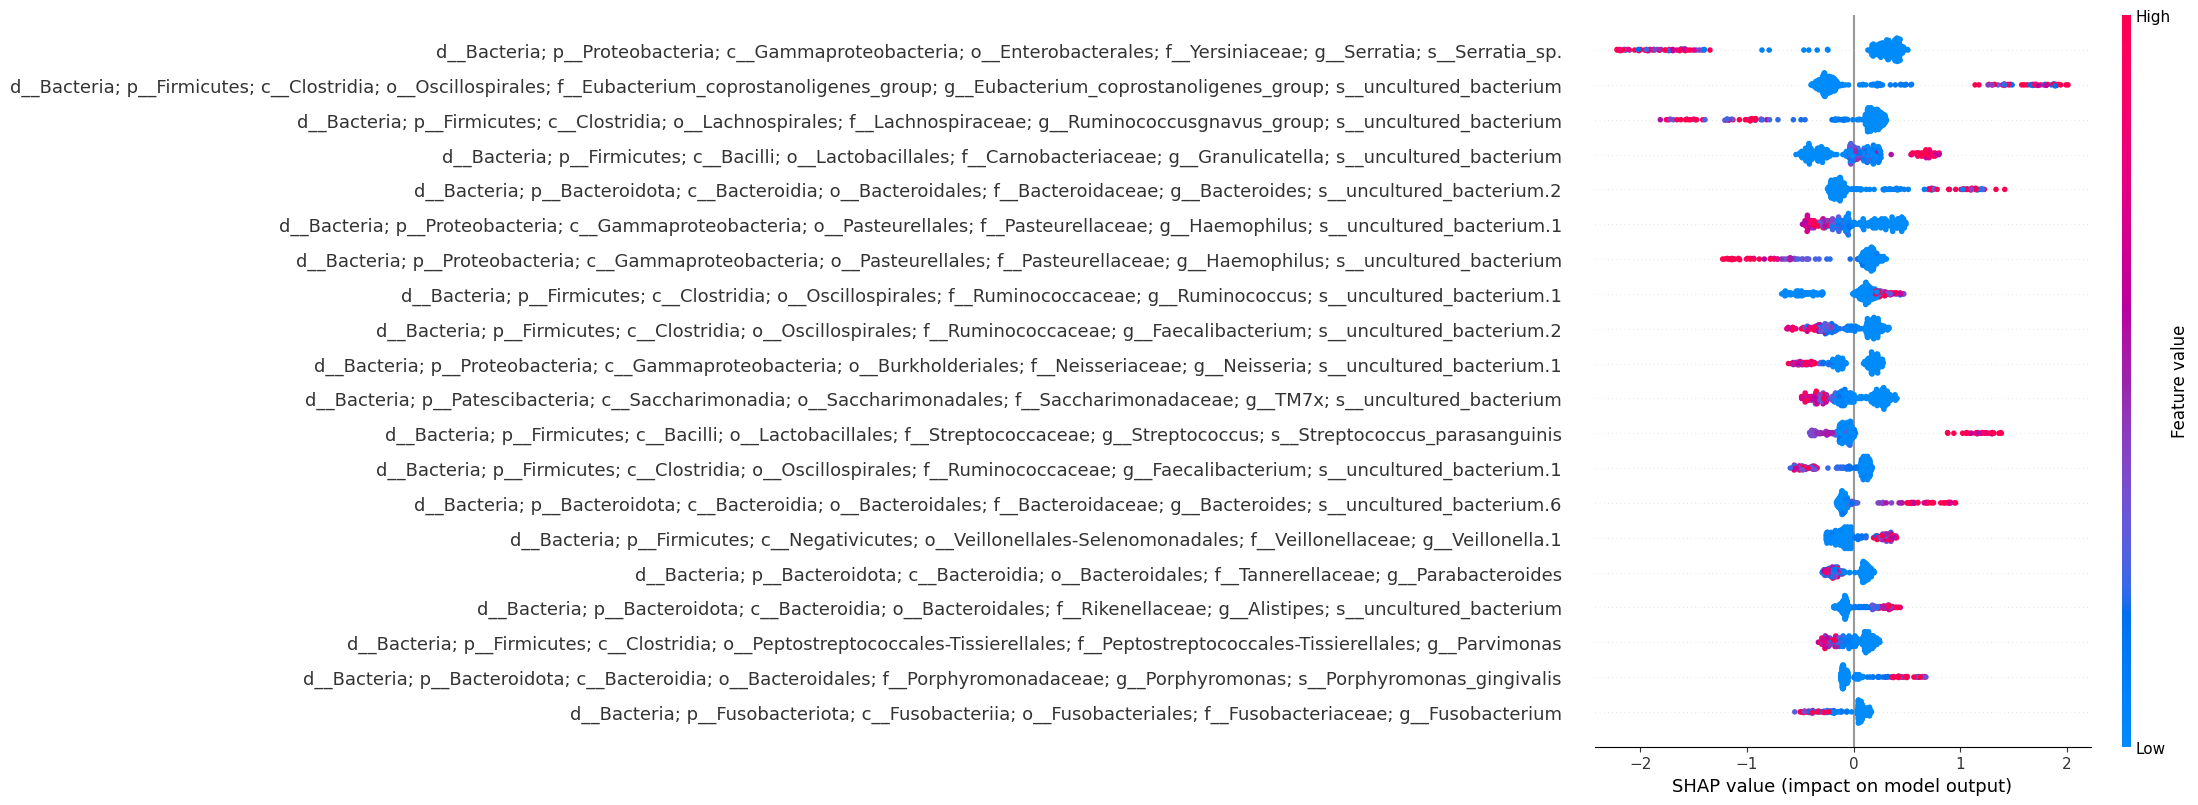

In [23]:
shap.summary_plot(shap_values, X, show = False)
plt.savefig('shap_64features_dataset1.png', dpi=55, bbox_inches='tight')

In [4]:
import matplotlib.pylab as pl
import numpy as np
from sklearn.metrics import classification_report
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import sklearn
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

AP_CRC_18['target'] = [0] * 172 + [1] * 172

X = AP_CRC_18.iloc[:, :-1]
y = AP_CRC_18.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

Cross-Validation Accuracy Scores:
[0.57142857 0.64285714 0.85714286 0.60714286 0.64285714 0.74074074
 0.7037037  0.88888889 0.77777778 0.7037037 ]
Mean Accuracy: 0.7136243386243386
Test Set Accuracy: 69.57%
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.54      0.64        35
           1       0.64      0.85      0.73        34

    accuracy                           0.70        69
   macro avg       0.72      0.70      0.69        69
weighted avg       0.72      0.70      0.69        69



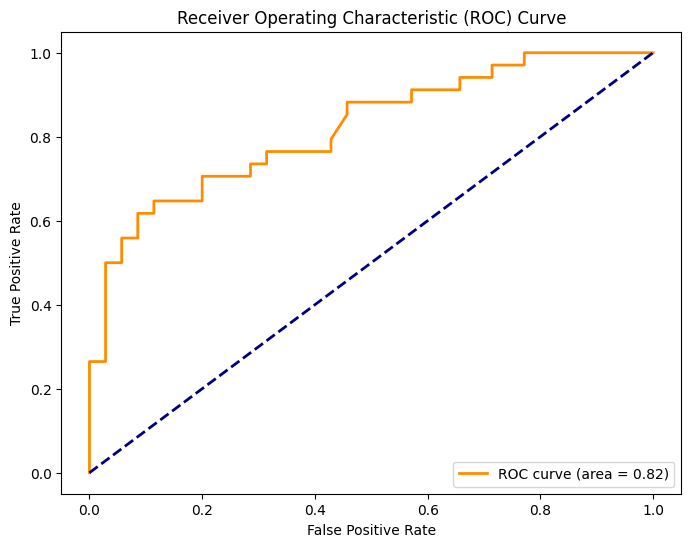

In [5]:
def print_accuracy(predictions):
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

svc_rbf = SVC(kernel="rbf", probability=True)

cv_scores = cross_val_score(svc_rbf, X_train, y_train, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

svc_rbf.fit(X_train, y_train)

y_pred = svc_rbf.predict(X_test)
y_pred_prob = svc_rbf.predict_proba(X_test)[:, 1]

print_accuracy(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [10]:
print_accuracy(svc_rbf.predict(X_test))
explainer = shap.KernelExplainer(svc_rbf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)


Using 275 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Test Set Accuracy: 69.57%


  0%|          | 0/69 [00:00<?, ?it/s]

In [11]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


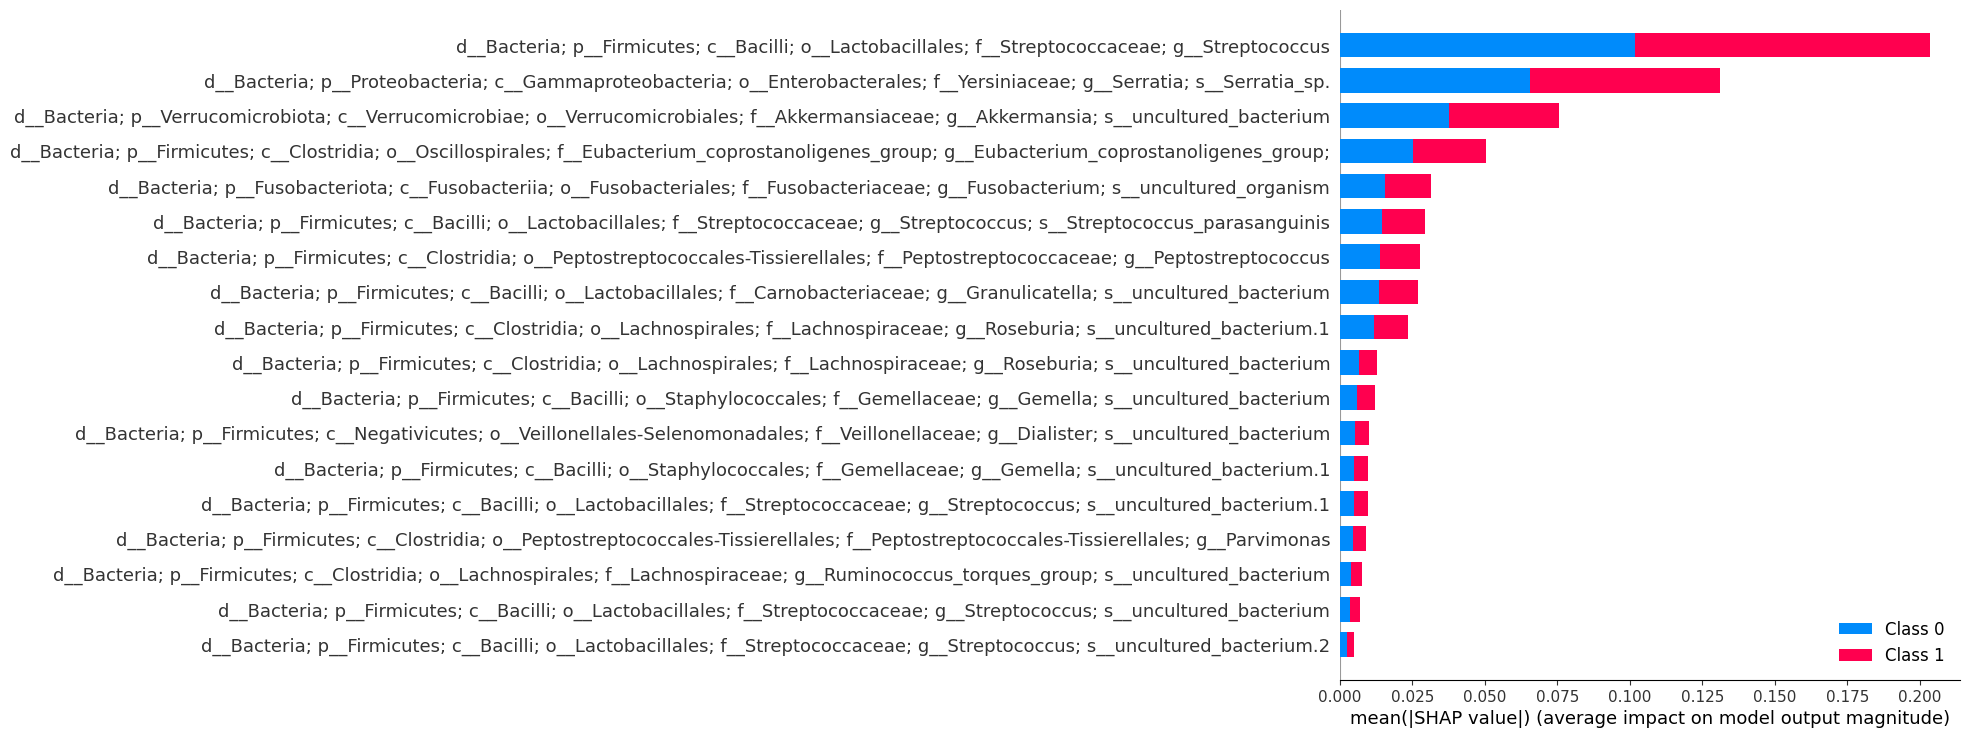

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [3]:
import matplotlib.pylab as pl
import numpy as np
from sklearn.metrics import classification_report
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import sklearn
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
AP_CRC64['target'] = [0] *172 + [1] * 172

X = AP_CRC64.iloc[:, :-1]
y = AP_CRC64.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

Cross-Validation Accuracy Scores:
[0.57142857 0.67857143 0.89285714 0.71428571 0.85714286 0.7037037
 0.85185185 0.81481481 0.77777778 0.77777778]
Mean Accuracy: 0.764021164021164
Test Set Accuracy: 69.57%
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73        35
           1       0.74      0.59      0.66        34

    accuracy                           0.70        69
   macro avg       0.70      0.69      0.69        69
weighted avg       0.70      0.70      0.69        69



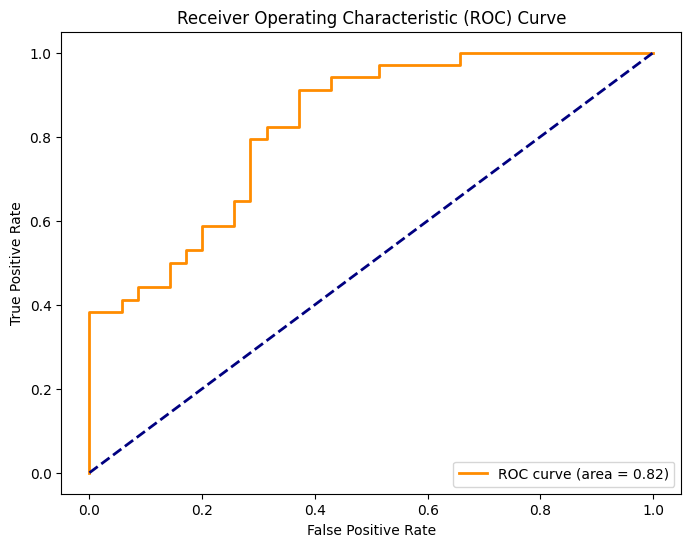

In [4]:
def print_accuracy(predictions):
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

svc_rbf = SVC(kernel="rbf", probability=True)

cv_scores = cross_val_score(svc_rbf, X_train, y_train, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

svc_rbf.fit(X_train, y_train)

y_pred = svc_rbf.predict(X_test)
y_pred_prob = svc_rbf.predict_proba(X_test)[:, 1]

print_accuracy(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [5]:
# Print accuracy on the test set
print_accuracy(svc_rbf.predict(X_test))

# Explain all the predictions in the test set
explainer = shap.KernelExplainer(svc_rbf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Using 275 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Test Set Accuracy: 69.57%


  0%|          | 0/69 [00:00<?, ?it/s]

In [6]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


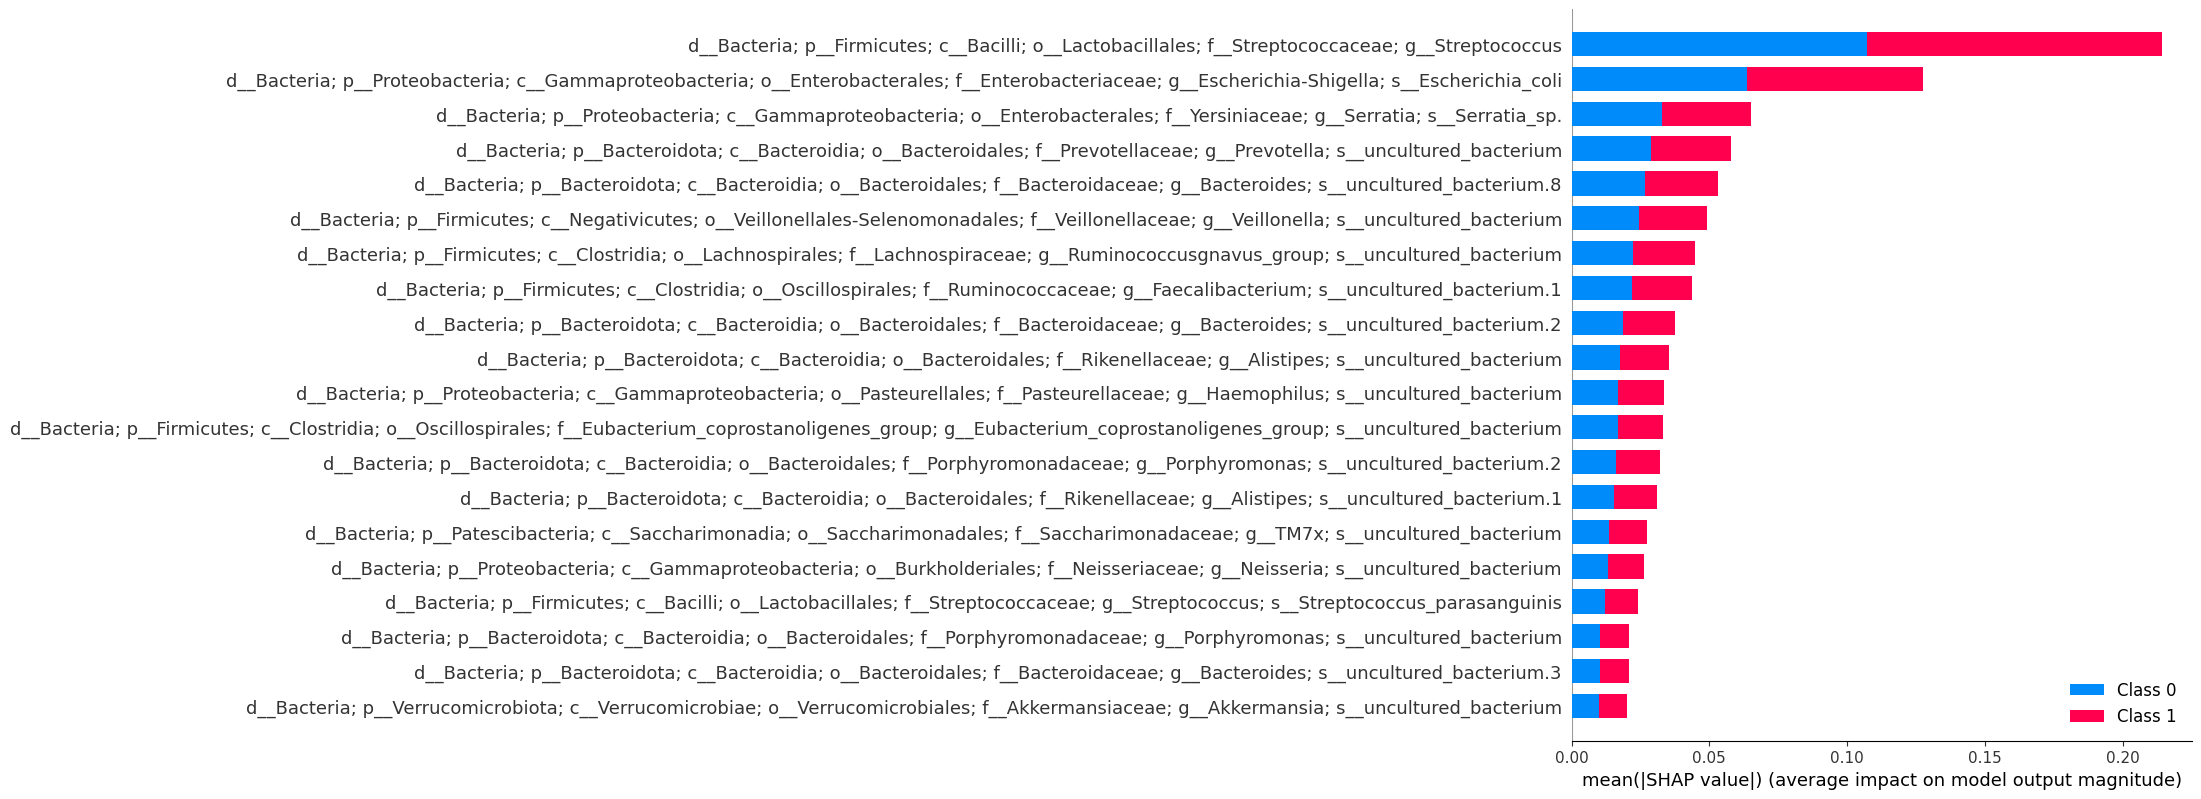

In [7]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import shap
import matplotlib.pyplot as plt

AP_CRC_18['target'] = [0] *172 + [1] * 172

X = AP_CRC_18.iloc[:, :-1]
y = AP_CRC_18.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cross-Validation Accuracy Scores:
[0.96428571 0.92857143 0.92857143 0.92857143 0.89285714 0.92592593
 0.92592593 0.77777778 0.92592593 0.88888889]
Mean Accuracy: 0.9087301587301587
Test Set Accuracy: 81.16%
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82        36
           1       0.81      0.79      0.80        33

    accuracy                           0.81        69
   macro avg       0.81      0.81      0.81        69
weighted avg       0.81      0.81      0.81        69



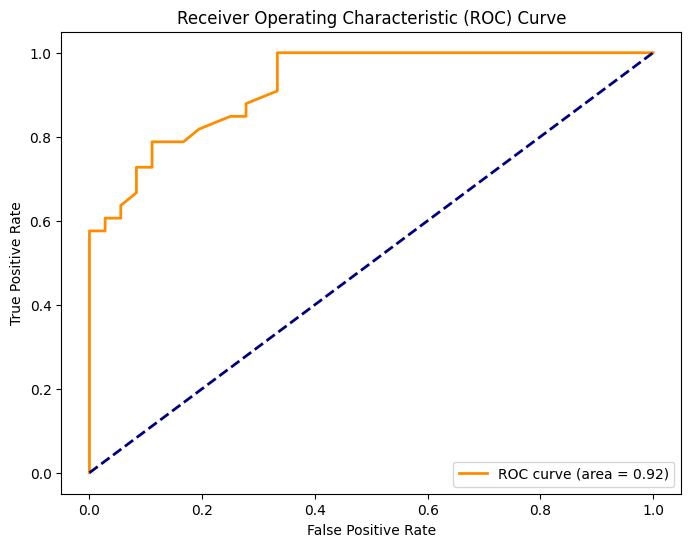

In [4]:
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_split=2)

cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

rf_classifier.fit(X_train, y_train)

def print_accuracy(predictions):
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

y_pred = rf_classifier.predict(X_test)
print_accuracy(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)

y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [5]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [6]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


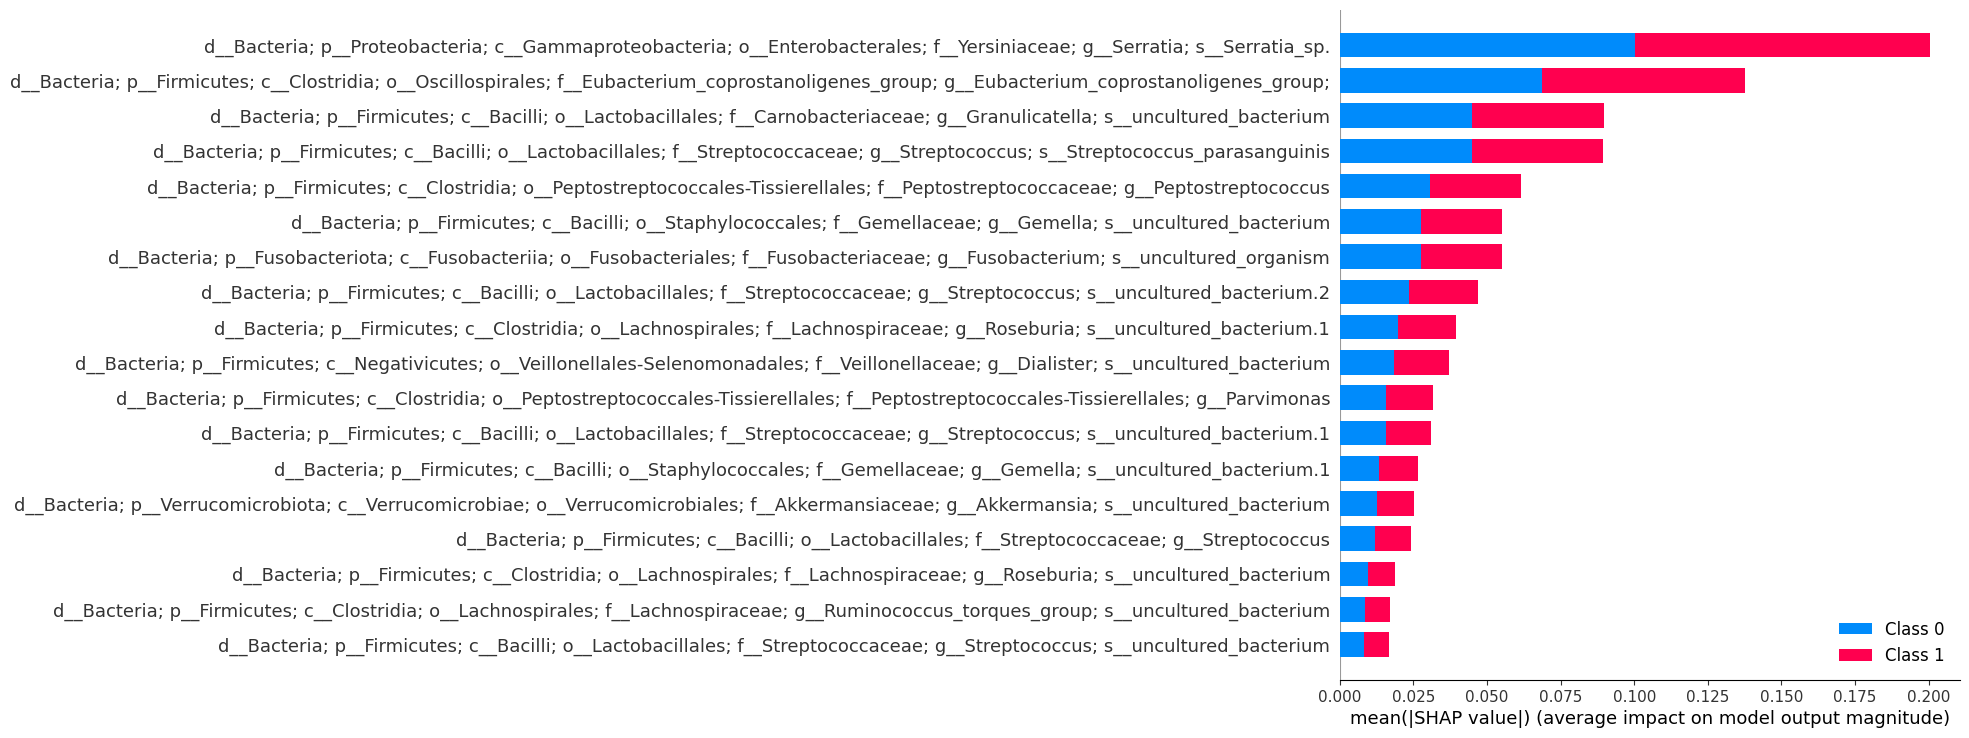

In [7]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import shap
import matplotlib.pyplot as plt

AP_CRC64['target'] = [0] *172 + [1] * 172

X = AP_CRC64.iloc[:, :-1]
y = AP_CRC64.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cross-Validation Accuracy Scores:
[1.         1.         0.96428571 0.92857143 1.         1.
 1.         0.92592593 0.96296296 0.96296296]
Mean Accuracy: 0.9744708994708995
Test Set Accuracy: 89.86%
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90        36
           1       0.86      0.94      0.90        33

    accuracy                           0.90        69
   macro avg       0.90      0.90      0.90        69
weighted avg       0.90      0.90      0.90        69



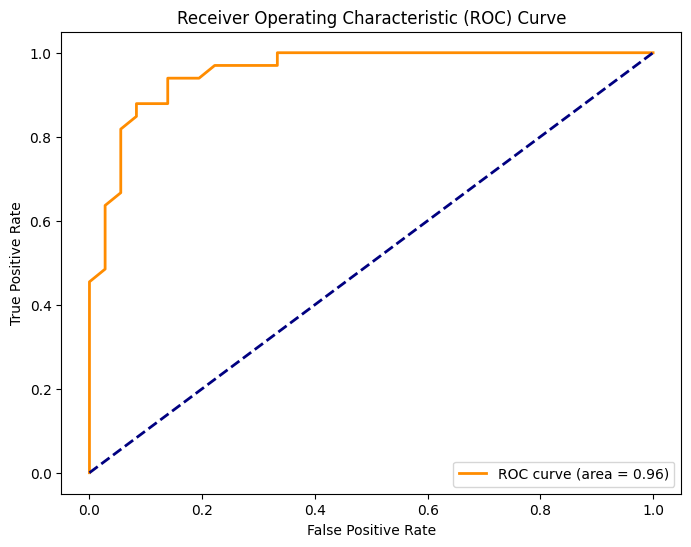

In [4]:
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_split=2)

cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

rf_classifier.fit(X_train, y_train)

def print_accuracy(predictions):
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

y_pred = rf_classifier.predict(X_test)
print_accuracy(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)

y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [5]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [6]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


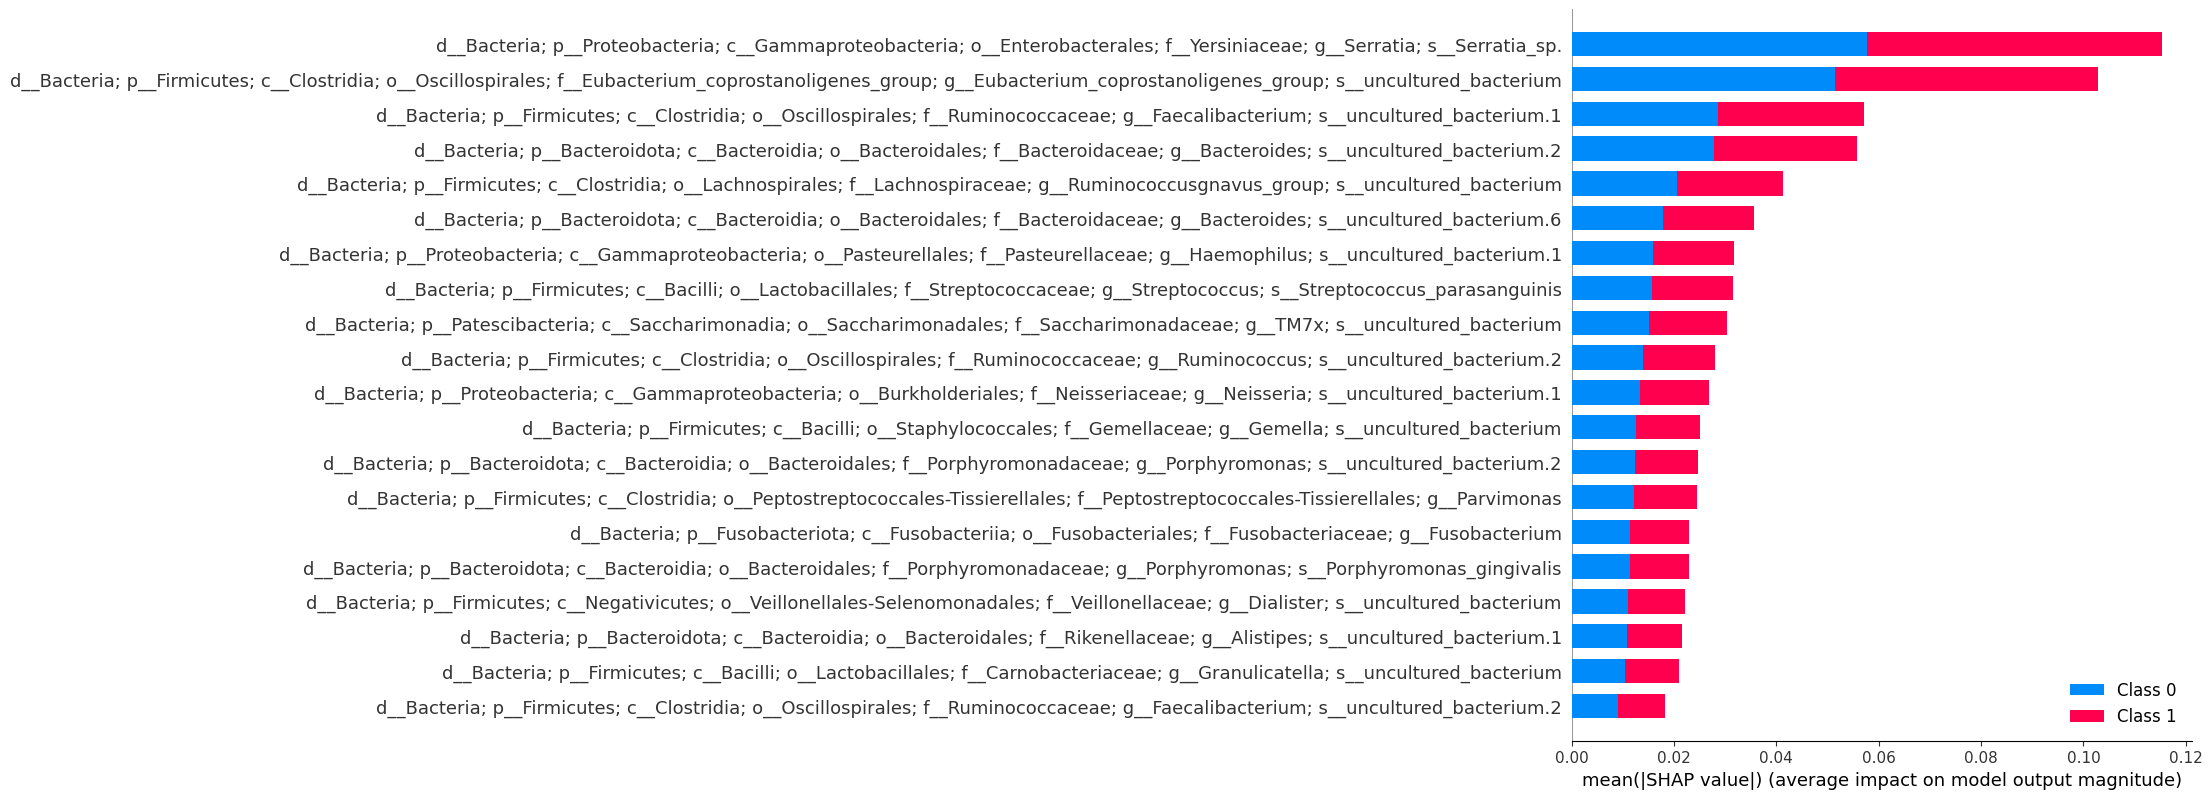

In [7]:
shap.summary_plot(shap_values, X, plot_type="bar")